<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## **MSDS453 - Research Assignment 02 - Classification and Clustering - Experimental Fine Tuning **

Clustering methods compute a similarity (or closeness) measure, such as Euclidean distance, in order to decide whether two documents are ‘similar’ or not.  

Use the entire class corpus and do sentiment analysis for the positive and negative reviews.

Topic modeling is another way to group ‘similar’ documents into ‘clusters’.

# **1. Modules and Loading Data Set via Google Drive**

In [ ]:
!pip install transformers datasets torch sklearn
!pip install datasets
!pip install transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Using cached datasets-2.18.0-py3-none-any.whl (510 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12

In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 5.0 MB/s eta 0:00:00


In [ ]:
!pip install transformers[torch] -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [ ]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

### Mount Google Drive to Colab Environment

<div class="alert alert-block alert-success">
    <b>Directories Required for Research Assignment</b>:<br>
1. Data Directory - Source Class Corpus Data<br>
2. Output Directory - Vocabulary<br>
</div>

#### Uncomment To Map Google Drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

&nbsp;

# **2. NLTK Downloads, etc, Data Wrangling Utility Functions, and Loading the Corpus**

In [ ]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [ ]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.2


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [ ]:
# COMMENTED OUT FUNCTIONS HERE NOT REFERENCED BY OTHER PARTS OF NOTEBOOK

def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

@dataclass
class Document:
    doc_id: str
    text: str

# def normalize_document(document: Document) -> Document:
#     text = document.text
#     text = remove_punctuation(text)
#     text = lower_case(text)
#     text = remove_tags(text)
#     text = remove_special_chars_and_digits(text)

#     return Document(document.doc_id, text)

# def normalize_documents(documents: List[Document]) -> List[Document]:
#     """
#     Normalizes text for all given documents.
#     Removes punctuation, converts to lower case, removes tags and special characters.
#     """
#     return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

# def tokenize_document(document: Document) -> TokenizedDocument:
#     tokens = nltk.word_tokenize(document.text)
#     return TokenizedDocument(document.doc_id, tokens)

# def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
#     return [tokenize_document(x) for x in documents]

# def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
#     result = []
#     lemmatizer = WordNetLemmatizer()
#     for document in documents:
#         output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
#         result.append(TokenizedDocument(document.doc_id, output_tokens))
#
#     return result

# def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
#     result = []
#     stemmer = PorterStemmer()
#     for document in documents:
#         output_tokens = [stemmer.stem(w) for w in document.tokens]
#         result.append(TokenizedDocument(document.doc_id, output_tokens))
#
#     return result

# def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
#     result = []
#
#     stop_words = set(nltk.corpus.stopwords.words('english'))
#     for document in documents:
#         filtered_tokens = [w for w in document.tokens if not w in stop_words]
#         result.append(TokenizedDocument(document.doc_id, filtered_tokens))
#
#     return result

# def add_flags(data: pd.DataFrame, casino_royale_doc_ids: List[int], action_doc_ids: List[int]):
#     data['is_casino_royale'] = data.index.isin(casino_royale_doc_ids)
#     data['is_action'] = data.index.isin(action_doc_ids)

# def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
#     tokens = {y for x in documents for y in x.tokens}
#     return sorted(list(tokens))

def clean_doc(doc):
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # word stemming
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

# def final_processed_text_disabled(doc):
#     #this is a function to join the processed text back
#     ' '.join(doc)
#     return doc

def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)

    #creating datafram from TFIDF Matrix

    # https://stackoverflow.com/questions/70215049/attributeerror-tfidfvectorizer-object-has-no-attribute-get-feature-names-out
    #words = Tfidf.get_feature_names() # For sklearn <= 0.24.x
    #matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

    words = Tfidf.get_feature_names_out() # For sklearn >= 1.0.x
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names_out(), index=titles)
    return matrix #,words

def One_Hot(variable):
    #this is a function to one hot encode the classes
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels

&nbsp;

# **3. Functions Latent Semantic Analysis, Latent Dirichlet Allocation, Word2Vec Matrix**
1. Latent Semantic Analysis
2. Latent Dirichlet Allocation
3. Word2Vec Matrix creation

In [ ]:
# def create_gensim_lsa_model(doc_clean,number_of_topics,words):

#     # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
#     dictionary = corpora.Dictionary(doc_clean)
#     # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
#     doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
#     # generate LSA model
#     # train model
#     lsamodel = LsiModel(doc_term_matrix
#                         ,num_topics=number_of_topics
#                         ,id2word = dictionary
#                         ,power_iters=100)
#     print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
#     index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

#     return lsamodel,dictionary,index

# def lsa(tfidf_matrix, terms, n_components = 10):
#     #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
#     #the desired number of components.

#     LSA = TruncatedSVD(n_components=10)
#     LSA.fit(tfidf_matrix)

#     for i, comp in enumerate(LSA.components_):
#         terms_comp = zip(terms, comp)
#         sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
#         print("Topic "+str(i)+": ")
#         for t in sorted_terms:
#             print(t[0])

# def create_gensim_lda_model(doc_clean,number_of_topics,words):

#     # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
#     dictionary = corpora.Dictionary(doc_clean)
#     # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
#     doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
#     # generate LDA model
#     ldamodel = LdaModel(doc_term_matrix
#                         ,num_topics=number_of_topics
#                         ,id2word = dictionary
#                         ,alpha='auto'
#                         ,eta='auto'
#                         ,iterations=100
#                         ,random_state=23
#                         ,passes=20)
#     # train model
#     print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
#     index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
#     return ldamodel,dictionary,index,doc_term_matrix

# def lda(tfidf_matrix, terms, topics = 3, num_words = 10):
#     #this is a function to perform lda on the tfidf matrix.  function varibales include:
#     #tfidf matrix, desired number of topic, and number of words per topic.

#     topics = 3
#     num_words = 10
#     lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

#     topic_dict = {}
#     for topic_num, topic in enumerate(lda.components_):
#         topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

#     print(topic_dict)

# def word2vec(processed_text, size = 100):
#     #This is a function to generate the word2vec matrix. Input parameters include the
#     #tokenized text and matrix size

#     #word to vec
#     model_w2v = Word2Vec(processed_text, vector_size=100, window=5, min_count=1, workers=4)

#     #join all processed DSI words into single list
#     processed_text_w2v=[]
#     for i in processed_text:
#         for k in i:
#             processed_text_w2v.append(k)

#     #obtian all the unique words from DSI
#     w2v_words=list(set(processed_text_w2v))

#     #can also use the get_feature_names() from TFIDF to get the list of words
#     #w2v_words=Tfidf.get_feature_names()

#     #empty dictionary to store words with vectors
#     w2v_vectors={}

#     #for loop to obtain weights for each word
#     for i in w2v_words:
#         temp_vec=model_w2v.wv[i]
#         w2v_vectors[i]=temp_vec

#     #create a final dataframe to view word vectors
#     w2v_df=pd.DataFrame(w2v_vectors).transpose()
#     print(w2v_df)
#     return w2v_df

## This code below is Experimental#1 and Barry wants your feedback if this works or not (Disabled)

In [ ]:
## Experimental#1 code here will show you the movie titles for the topics
## Uncomment all the code in this cell and it will override the above functions
## Also switch ot the modified Experiment#1 code lines elsewhere to add the "titles" parameter
## or you can ignore the commented lines for Experiment#1 code and continue your assignment.

# def create_gensim_lda_model(doc_clean,number_of_topics,words, titles):
#
#     dictionary = corpora.Dictionary(doc_clean)
#     doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
#     ldamodel = LdaModel(doc_term_matrix ,num_topics=number_of_topics,id2word = dictionary,alpha='auto',
#                                           eta='auto',iterations=100,random_state=23,passes=20)
#     print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
#     index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
#
#     # THIS CODE BELOW IS EXPERIMENTAL#1 AND BARRY WANTS YOUR FEEDBACK IF THIS WORKS OR NOT
#
#     # Method 1: Shows top 5 titles related to a topic; adjust the number accordingly.
#     for topic in ldamodel.print_topics(num_topics=number_of_topics, num_words=words):
#         topic_number = topic[0]
#         sims = index[ldamodel[doc_term_matrix[topic_number]]]
#         most_similar_titles = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])[:5]]
#         print('Most similar titles for topic #{}: {}'.format(topic_number, most_similar_titles))
#
#     # Method 2: Shows all titles sorted on most similar for each topic.
#     # Note you get all titles for all topics!
#
#     for document in doc_clean:
#         doc_bow = dictionary.doc2bow(document)
#         sims = index[ldamodel[doc_bow]]
#         most_similar_topic = sorted(enumerate(sims), key=lambda item: -item[1])[0][0]
#         #VERBOSE DEBUGGING: print('Document belongs to topic #{}'.format(most_similar_topic))
#
#     topic_titles = {}
#     for topic_number, topic in enumerate(ldamodel.print_topics(num_topics=number_of_topics, num_words=words)):
#         sims = index[ldamodel[doc_term_matrix[topic_number]]]
#         titles_for_topic = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])]
#         topic_titles[topic_number] = titles_for_topic
#         print('Titles for topic #{}: {}'.format(topic_number, titles_for_topic))
#
#     return ldamodel,dictionary,index,doc_term_matrix

###########

# def create_gensim_lsa_model(doc_clean, number_of_topics, words, titles):
#
#     dictionary = corpora.Dictionary(doc_clean)
#     doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
#
#     # generate LSA model
#     lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word=dictionary, power_iters=100)
#
#     print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
#     index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])
#
#     # THIS CODE BELOW IS EXPERIMENTAL AND BARRY WANTS YOUR FEEDBACK IF THIS WORKS OR NOT
#
#     # Method 1: Shows top 5 titles related to a topic; adjust the number accordingly.
#     for topic in lsamodel.print_topics(num_topics=number_of_topics, num_words=words):
#         topic_number = topic[0]
#         sims = index[lsamodel[doc_term_matrix[topic_number]]]
#         most_similar_titles = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])[:5]]
#         print('Most similar titles for topic #{}: {}'.format(topic_number, most_similar_titles))
#
#     # Method 2: Shows all titles sorted on most similar for each topic.
#     # Note you get all titles for all topics!
#
#     for document in doc_clean:
#         doc_bow = dictionary.doc2bow(document)
#         sims = index[lsamodel[doc_bow]]
#         most_similar_topic = sorted(enumerate(sims), key=lambda item: -item[1])[0][0]
#         #VERBOSE DEBUGGING: print('Document belongs to topic #{}'.format(most_similar_topic))
#
#     topic_titles = {}
#     for topic_number, topic in enumerate(lsamodel.print_topics(num_topics=number_of_topics, num_words=words)):
#         sims = index[lsamodel[doc_term_matrix[topic_number]]]
#         titles_for_topic = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])]
#         topic_titles[topic_number] = titles_for_topic
#         print('Titles for topic #{}: {}'.format(topic_number, titles_for_topic))
#
#     return lsamodel, dictionary, index
#
############
##
## When you call create_gensim_lda_model(...) later on, you have to add titles to the call. Eg:
##
## model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words,titles)
##
## Similarly for LSA...

# **4. Modeling Functions: KMeans, SVM, Logistic, Naive Bayes, Randomforest, BERTopic**

In [ ]:
# DISABLED

# def k_means(titles, tfidf_matrix, k=3):

#     #this is a function to generate the k-means output using the tfidf matrix.  Inputs
#     #to the function include: titles of text, processed text, and desired k value.
#     #Returns dataframe indicating cluster number per document

#     km = KMeans(n_clusters=k, random_state =89)
#     km.fit(tfidf_matrix)
#     clusters = km.labels_.tolist()

#     Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
#     frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
#     #dictionary to store clusters and respective titles
#     cluster_title={}

#     #note doc2vec clusters will not have individual words due to the vector representation
#     #is based on the entire document not indvidual words. As a result, there won't be individual
#     #word outputs from each cluster.
#     for i in range(k):
#         temp=frame[frame['Cluster']==i]
#         temp_title_list=[]
#         for title in temp['Doc Name']:
#             temp_title_list.append(title)
#         cluster_title[i]=temp_title_list

#     # How to see the results of the k-means clustering
#     #print ("cluster_title", cluster_title)
#     #print ("clusters", clusters)
#     #print ("frame", frame)
#     return cluster_title,clusters,frame

# def bert_pretrained(texts):
#     # Initialize the classifier
#     classifier = pipeline("sentiment-analysis")

#     # Perform sentiment analysis
#     results = []
#     for text in texts:
#         # Since the classifier can only handle a certain amount of text,
#         # you might need to truncate or split the text accordingly.
#         result = classifier(text[:512])  # Adjust if necessary
#         results.append(result)

#     return results

# def classifiers(x, y, model_type, cv = 3):

#     #this function is to fit 3 different model scenarios.  Support vector machines, logistic regressions, naive bayes.
#     #svm = Support vector machin
#     #logistic = Logistic regression
#     #naive_bayes = Naive Bayes Multinomial

#     #can define cv value for cross validation.

#     #function returns the train test split scores of each model.

#     if model_type == 'svm':
#         print("svm")
#         model = SVC()

#     elif model_type == 'logistic':
#         print("logistic")
#         model = LogisticRegression()

#     elif model_type == 'naive_bayes':
#         print("naive_bayes")
#         model = MultinomialNB()

#     elif model_type == 'randomforest':
#         print("randomforest")
#         model = RandomForestClassifier()

#     X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=23)
#     model.fit(X_train, y_train)

#     predictions = model.predict(X_test)
#     accy = accuracy_score(y_test, predictions)
#     return accy

## Visualization Utility Functions (Disabled)

In [ ]:
# def plot_lsa(number_of_topics, words):

#     # BARRYC experimental#1
#     #model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words,titles)
#     model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

#     for doc in processed_text:
#         vec_bow = dictionary.doc2bow(doc)
#         vec_lsi = model[vec_bow]  # convert the query to LSI space
#         sims = index[vec_lsi] # perform a similarity query against the corpus

#     fig, ax = plt.subplots(figsize=(30, 10))
#     cax = ax.matshow(index, interpolation='nearest')
#     ax.grid(True)
#     plt.xticks(range(len(processed_text)), titles, rotation=90);
#     plt.yticks(range(len(processed_text)), titles);
#     fig.colorbar(cax)
#     plt.show()
#     return model

# def plot_tfidf_matrix(cluster_title,clusters,TFIDF_matrix):
#     # convert two components as we're plotting points in a two-dimensional plane
#     # "precomputed" because we provide a distance matrix
#     # we will also specify `random_state` so the plot is reproducible.

#     mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
#     dist = 1 - cosine_similarity(TFIDF_matrix)
#     pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
#     xs, ys = pos[:, 0], pos[:, 1]


#     #set up colors per clusters using a dict.  number of colors must correspond to K
#     cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick',
#                       5:'red', 6:'darksalmon', 7:'sienna'}

#     #set up cluster names using a dict.
#     cluster_dict=cluster_title

#     #create data frame that has the result of the MDS plus the cluster numbers and titles
#     df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters))))

#     #group by cluster
#     groups = df.groupby('label')

#     fig, ax = plt.subplots(figsize=(20,20)) # set size
#     ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#     #iterate through groups to layer the plot
#     #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
#     for name, group in groups:

#         r = random.random()
#         b = random.random()
#         g = random.random()
#         color = (r, g, b)

#         ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
#                 label=cluster_dict[name], color=color,
#                 mec='none')
#         ax.set_aspect('auto')
#         ax.tick_params(\
#             axis= 'x',          # changes apply to the x-axis
#             which='both',      # both major and minor ticks are affected
#             bottom='off',      # ticks along the bottom edge are off
#             top='off',         # ticks along the top edge are off
#             labelbottom='on')
#         ax.tick_params(\
#             axis= 'y',         # changes apply to the y-axis
#             which='both',      # both major and minor ticks are affected
#             left='off',      # ticks along the bottom edge are off
#             top='off',         # ticks along the top edge are off
#             labelleft='on')

#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})      #show legend with only 1 point

## Loading the Class Corpus

In [ ]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_NLP/main/MSDS453_ClassCorpus/MSDS453_QA_20220906.csv'
data = get_corpus_df(CORPUS_PATH)

In [ ]:
#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text'].tolist()

1. Dataframe = corpus_df
2. List = documents (Document ID, Text)

&nbsp;

# **5. Exploratory Data Analysis**

In [ ]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_NLP/main/MSDS453_ClassCorpus/MSDS453_QA_20220906.csv'
corpus_df = get_corpus_df(CORPUS_PATH)
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

In [ ]:
# corpus_df.shape

In [ ]:
# corpus_df.head().T

In [ ]:
# print(corpus_df.info());

In [ ]:
# print(corpus_df['Movie Title'].unique())

(Disabled)
<s>Exploring different numbers of...


> LSA: **2**, **6**, **20** concepts and **10** words<br>
> LDA: **2**, **6**, **20** topics and **10** words<br>

1.   *Model Complexity*
2.   *Model Interpretability*
3.   *Evaluation of Coherence*
4.   *Avoid Overfitting*
5.   *Practical Implications*
6.   *Computational Implications*
</s>

## Latent Semantic Analysis - Research Number of Topics and Number of Words (Disabled)

### Plotting 2 concepts and 10 words

In [ ]:
#model_2concepts_10words=plot_lsa(2, 10)

### Plotting 6 concepts and 10 words

In [ ]:
#model_6concepts_10words=plot_lsa(6, 10)

### Plotting 20 concepts and 10 words

In [ ]:
#model_20concepts_10words=plot_lsa(20, 10)

### Compare LSA Model Coherence (Disabled)

In [ ]:
# topics = [6, 2, 10]
# coherence_values = []
# for t in topics:
#     #BARRYC EXPERIMENTAL#1
#     #lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10, titles)
#     lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10)


#     coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
#     coherence_lsa = coherence_model_lsa.get_coherence()
#     coherence_values.append(coherence_lsa)


# coherence ={'6 concepts 10 words':coherence_values[0],
#            '2 concepts 10 words': coherence_values[1],
#            '20 concepts 10 words':coherence_values[2]}

# print(coherence)

## Latent Dirichlet Allocation - Research Number of Topics and Number of Words (Disabled)

In [ ]:
# ######################################
# #EXPERIMENT WITH THESE PARAMETERS
# number_of_topics=4
# words=20
# #####################################

In [ ]:
# # BARRYC EXPERIMENTAL#1
# #model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words,titles)
# model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words)

# for doc in processed_text:
#     vec_bow2 = dictionary2.doc2bow(doc)
#     vec2 = model2[vec_bow2]  # convert the query to embedded space
#     sims2 = index2[vec2]  # perform a similarity query against the corpus
#     #print(list(enumerate(sims2)))

# fig, ax = plt.subplots(figsize=(30, 10))
# cax = ax.matshow(index2, interpolation='nearest')
# ax.grid(True)
# plt.xticks(range(len(processed_text)), titles, rotation=90);
# plt.yticks(range(len(processed_text)), titles);
# fig.colorbar(cax)
# plt.show()

### Compare LDA Model Coherence

In [ ]:
# topics = [6, 2, 10]
# coherence_values = []
# for t in topics:
#     #BARRYC EXPERIMENTAL#1
#     #ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10,titles)
#     ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10)


#     coherence_model_lda = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     coherence_values.append(coherence_lda)


# coherence ={'6 topic 10 words':coherence_values[0],
#            '2 topic 10 words': coherence_values[1],
#            '20 topic 10 words':coherence_values[2]}

# print(coherence)

# **BERTopic** (Disabled)

This section of the code demonstrates the BERTopic library to extract topics and visualize the distribution and relationships between them.

You've already done preprocessing earlier by cleaning the text by removing punctuation, filtering out stop words and short tokens, and converting text to lowercase. You could also try with the raw sentences too!

Then there is topic modeling with BERTopic to identify and analyze underlying themes in the dataset.

&nbsp;

In [ ]:
#!pip install bertopic

In [ ]:
# import re,string
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer

# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# import matplotlib.pyplot as plt

# import pandas as pd
# import os
# import numpy as np
# from bertopic import BERTopic
# import warnings
# warnings.filterwarnings('ignore')

In [ ]:
# ALREADY DONE EARLIER

# import nltk
# nltk.download('stopwords')

#functions used to process text and create the required TFIDF and Doc2vec Matrices
# def clean_doc(doc):
#     ...

# def final_processed_text(doc):
#     #this is a function to join the processed text back
#     ...

In [ ]:
# ALREADY DONE EARLIER

# #read in class corpus csv into python
# data=pd.read_csv(r'MSDS453_QA_20220906.csv')

# #adding two columns to the dataframe to store the processed text and tokenized text
# data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

# #creating final processed text variables for matrix creation
# final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
# titles = data['Movie Title'].tolist()
# processed_text = data['processed_text'].tolist()

In [ ]:
len(final_processed_text)

200

In [ ]:
final_processed_text[1]

'muttered entered first screening local cinema sunny friday afternoon summer stretch people beach something third movie increasinglyludicrous series talking mayonnaise gerard butler despite overwhelming going spend excuse people whoever movie manage least improve execrable racist followup known channing tatumjamie teamup house happy assorted tropes clichés genre featuring convoluted narrative packed inexplicable decisionmaking totally telegraphed betrayals meaningless technobabble jargon along loads grimaces steely glares never better banning gerard butler still toplevel secret service agent assigned protection detail president trumbull morgan freeman poison trusts implicitly considering assume position director secret service following impending retirement current honcho gentry lance reddick chapter folks consider piper perabo likes behind military buddy danny huston likes someone everyone seems think doubts especially since struggling physical psychological years matters however coor

In [ ]:
# from bertopic import BERTopic
# topic_model = BERTopic(min_topic_size=2)

In [ ]:
# topics, probs = topic_model.fit_transform(final_processed_text)

In [ ]:
# topic_model.get_topic_info()

In [ ]:
# topic_model.visualize_barchart()

In [ ]:
# topic_model.visualize_heatmap()

In [ ]:
# topic_model.get_document_info(final_processed_text)

# **6. Cluster Model Research: KMeans, SVM, Logistic, Naive Bayes, Randomforest, BERT**


## NLP Supervised and Unsupervised Learning Methods:
1. K-Means Clustering (Unsupervised)
2. Support Vector Machines (SVMs) (Supervised)
3. (Multinomial) Naïve Bayes (MultinomialNB) (Supervised)
4. Logistic Regression (Supervised)

### Generate TF-IDF For Analysis

In [ ]:
tfidf_matrix = tfidf(final_processed_text, titles, ngram_range = (1,1))

### KMeans Clustering

<div class="alert alert-block alert-success">
    <b>sklearn.cluster.KMeans</b>:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html<br><br>
<b>KMeans Default Parameters</b>:<br>
    class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
    </div>

In [ ]:
# cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k=20)

### Access Each Cluster - Changing Dictionary KeyValue from 0 to k

In [ ]:
# cluster_title[9]

In [ ]:
# plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

### Generate Labels for Supervised Learning Models

In [ ]:
labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(labels)

Doc_ID
40     0
41     0
42     0
43     0
44     0
      ..
190    1
193    1
194    1
195    1
199    1
Name: Review Type (pos or neg), Length: 200, dtype: int64


### Support Vector Machines

<div class="alert alert-block alert-success">
    <b>Support vector machines (SVMs)</b>:<br>
https://scikit-learn.org/stable/modules/svm.html<br><br>
    Set of supervised learning methods used for classification, regression and outliers detection
    </div>

In [ ]:
#classifiers(tfidf_matrix, labels, 'svm')

### Logistic Regression Model

<div class="alert alert-block alert-success">
    <b>sklearn.linear_model.LogisticRegression</b>:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html<br><br>
<b>Logistic Regression Default Parameters</b>:<br>
    class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
    </div>

In [ ]:
#classifiers(tfidf_matrix, labels, 'logistic')

### Naive Bayes

<div class="alert alert-block alert-success">
    <b>Naive Bayes</b>:<br>
https://scikit-learn.org/stable/modules/naive_bayes.html<br><br>
    Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.
    </div>

In [ ]:
#classifiers(tfidf_matrix, labels, 'naive_bayes')

### Random Forest

<div class="alert alert-block alert-success">
    <b>sklearn.ensemble.RandomForestClassifier</b>:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html<br><br>
<b>RandomForest Classifier Default Parameters</b>:<br>
    class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
    </div>

In [ ]:
#classifiers(tfidf_matrix, labels, 'randomforest')

### BERT Pre-Trained Binary Classification (Sentiment-Analysis)

We use the pre-trained DistilBERT model "sentiment-analysis" fine-tuned for sentiment analysis to categorize text sentiments into positive, negative, or neutral.

https://wellsr.com/python/hugging-face-pipelines-for-python-natural-language-processing/

In [ ]:
def bert_classifier_binary(texts, labels):
    # Initialize the sentiment-analysis pipeline
    classifier = pipeline("sentiment-analysis")

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.10, random_state=42)

    # Perform sentiment analysis
    results = classifier(X_test, truncation=True)

    # Map BERT's output to binary labels
    predictions = [0 if result['label'] == 'NEGATIVE' else 1 for result in results]

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f"Binary Classification Accuracy: {accuracy}")
    return accuracy

In [ ]:
# How about the raw text?
raw_text = [text.strip().lower() for text in data['Text']]

raw_text[:1]

['boredom sets in long before the start of angel has fallen. i start my journey to the movie by changing out of my work clothes into something more comfortable. instead of something complex like a dress shirt with buttons and a collar along with khaki pants that require a belt, i wear a loose-fitting t-shirt and a light pair of cargo shorts. i want something simple and uncomplicated, like the plot to an action movie boiled down to \x93guy is framed, guy wants revenge, guy kills guys for revenge.\x94 it took only one person to pick out both of my outfits for the day, an accomplishment that seems remarkable compared to the three people who wrote the script to angel has fallen, completely different from the two people who wrote the story of said movie. a total of five people were needed to tell another convoluted story of gerard butler running from slightly-bearded men with guns for two hours. compared to the 15 minutes it took me to figure out the clothes appropriate for the day, it\x92s

In [ ]:
import re

def clean_non_ascii(text):
    # Replace common non-ASCII characters with their ASCII equivalents
    text = text.replace('\x93', '"').replace('\x94', '"')  # Smart double quotes
    text = text.replace('\x91', "'").replace('\x92', "'")  # Smart single quotes
    text = text.replace('\x96', '-').replace('\x97', '-')  # Long dashes

    # Remove any remaining non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    return text

raw_text_cleaned = [clean_non_ascii(text) for text in raw_text]
raw_text_cleaned[:1]

['boredom sets in long before the start of angel has fallen. i start my journey to the movie by changing out of my work clothes into something more comfortable. instead of something complex like a dress shirt with buttons and a collar along with khaki pants that require a belt, i wear a loose-fitting t-shirt and a light pair of cargo shorts. i want something simple and uncomplicated, like the plot to an action movie boiled down to "guy is framed, guy wants revenge, guy kills guys for revenge." it took only one person to pick out both of my outfits for the day, an accomplishment that seems remarkable compared to the three people who wrote the script to angel has fallen, completely different from the two people who wrote the story of said movie. a total of five people were needed to tell another convoluted story of gerard butler running from slightly-bearded men with guns for two hours. compared to the 15 minutes it took me to figure out the clothes appropriate for the day, it\'s hard to

In [ ]:
# Compare raw text with final processed text:

data['final_processed_text'] = final_processed_text

data['raw_text'] = raw_text
#data['raw_text'] = raw_text_cleaned

comparison_df = pd.DataFrame({
    'Label': labels,
    'Processed_Text': data['final_processed_text'],
    'Raw_Text': data['raw_text']
})

print(comparison_df)


        Label                                     Processed_Text  \
Doc_ID                                                             
40          0  boredom start angel fallen start journey movie...   
41          0  muttered entered first screening local cinema ...   
42          0  roman angel fallen secret service agent bannin...   
43          0  certain mindless pleasure fallen movies watchi...   
44          0  andor understand eminently disposable third ch...   
...       ...                                                ...   
190         1  diesel suddenly largely unknown actor whose si...   
193         1  packed razzledazzle special effects fueled agg...   
194         1  richard riddick diesel remain unconscious cryo...   
195         1  whats passenger spaceship rogue asteroid comet...   
199         1  sometimes movie value casablanca shocking soun...   

                                                 Raw_Text  
Doc_ID                                                 

In [ ]:
#bert_classifier_binary(raw_text, labels)

In [ ]:
#bert_classifier_binary(raw_text_cleaned, labels)

In [ ]:
#bert_classifier_binary(final_processed_text, labels)

### BERT Pre-Trained Multiple Classification (Genre)

Our genre classification utilizes a BERT-based uncased model to distinguish text genres. This approach capitalizes on BERT's deep semantic understanding from uncased text, aiming for genre identification.

https://huggingface.co/google-bert/bert-base-uncased

In [ ]:
# Good for quick assessment of model accuracy within function
def bert_classifier_multiple_simple(texts, labels):
    # Encode labels
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(texts, encoded_labels, test_size=0.10, random_state=42)

    # Load a tokenizer and model suited for your multi-class task
    #tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    #tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    #model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(encoder.classes_))
    #model = AutoModelForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=len(encoder.classes_))
    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(encoder.classes_))

    # Initialize the pipeline
    classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

    # Perform classification
    results = classifier(X_test, truncation=True)

    # Decode predictions to original labels
    predictions = [int(result['label'].split('_')[-1]) for result in results]
    decoded_predictions = encoder.inverse_transform(predictions)

    # Calculate accuracy
    decoded_y_test = encoder.inverse_transform(y_test)
    accuracy = accuracy_score(decoded_y_test, decoded_predictions)
    print(f"Multi-class Classification Accuracy: {accuracy}")
    return accuracy


In [ ]:
bert_classifier_multiple_simple(final_processed_text, data["Genre of Movie"])

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Multi-class Classification Accuracy: 0.1


0.1

In [ ]:
bert_classifier_multiple_simple(raw_text, data["Genre of Movie"])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Multi-class Classification Accuracy: 0.15


0.15

In [ ]:
bert_classifier_multiple_simple(raw_text_cleaned, data["Genre of Movie"])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Multi-class Classification Accuracy: 0.35


0.35

### Confusion Matrix

This code snippet generates a confusion matrix to visually evaluate the performance of our classification model by comparing the actual versus predicted labels.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Better suited for scenarios where you need to do more detailed post-processing or evaluation of the model’s performance
# Returning both sets of labels and the encoder allows you to compute additional metrics (like precision, recall, F1 score),
# generate confusion matrices, and perform more detailed error analyses outside the function.
# This version is preferable when you are finalizing your model or preparing to present detailed results and insights.
def bert_classifier_multiple(texts, labels):
    # Initialize and fit the label encoder
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(texts, encoded_labels, test_size=0.10, random_state=42)

    # Load a tokenizer and model suited for the multi-class task
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    #tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")

    model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(encoder.classes_))
    #model = AutoModelForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=len(encoder.classes_))

    # Initialize the pipeline
    classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

    # Perform classification
    results = classifier(X_test, truncation=True)

    # Process predictions
    predictions = [int(result['label'].split('_')[-1]) for result in results]

    # Decode predictions and true labels back to original labels
    decoded_predictions = encoder.inverse_transform(predictions)
    decoded_y_test = encoder.inverse_transform(y_test)

    # Return the true labels, predicted labels, and the encoder (for plotting confusion matrix)
    return decoded_y_test, decoded_predictions, encoder

# Assuming `data["Genre of Movie"]` is your labels array
true_labels, predicted_labels, encoder = bert_classifier_multiple(final_processed_text, data["Genre of Movie"])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


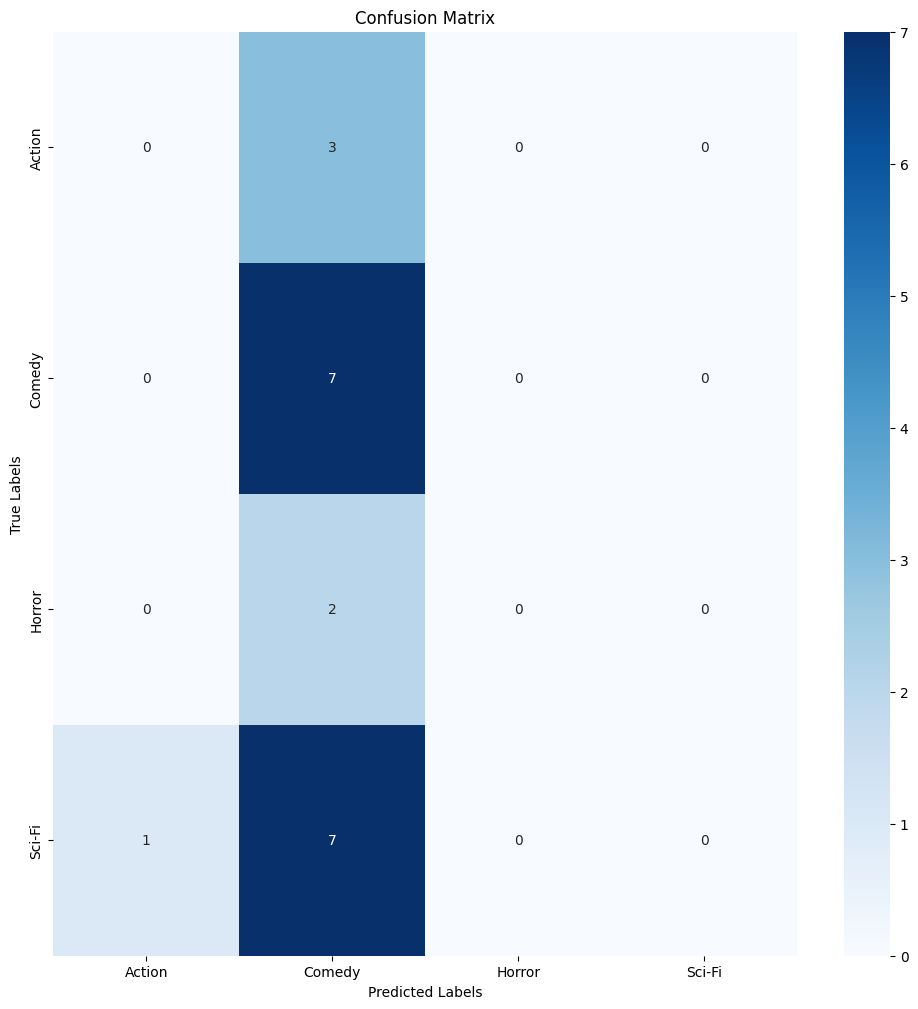

In [ ]:
def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels, labels=classes)
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

plot_confusion_matrix(true_labels, predicted_labels, encoder.classes_)


In [ ]:

from sklearn.metrics import confusion_matrix
import pandas as pd

def print_confusion_matrix(true_labels, predicted_labels, classes):
    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=classes)

    # Create a DataFrame from the confusion matrix
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(cm_df)

# Call the function with the true labels, predicted labels, and class names
print_confusion_matrix(true_labels, predicted_labels, encoder.classes_)


Confusion Matrix:
        Action  Comedy  Horror  Sci-Fi
Action       0       3       0       0
Comedy       0       7       0       0
Horror       0       2       0       0
Sci-Fi       1       7       0       0


In [ ]:
# !pip install transformers datasets torch sklearn
# !pip install datasets
# !pip install transformers torch

In [ ]:
#!pip install accelerate -U

In [ ]:
#!pip install transformers[torch] -U

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer

# Take out every 5th row
#data_subset= data.iloc[::5].copy()

#####
import numpy as np

# Calculate the total number of pairs you want
num_pairs = 80  # Adjust this to get the desired number of rows (e.g., 40 pairs for 80 rows)
# Changed to 80 pairs for the full 160 rows of the 2024 Summer class corpus

# Generate the indices for the first row of each pair
first_indices = np.arange(1, num_pairs*5, 5) - 1  # Subtract 1 because DataFrame indexing is 0-based

# Generate the indices for the second row of each pair by adding 1
second_indices = first_indices + 1
third_indices = first_indices + 2

# Combine the two arrays of indices
selected_indices = np.sort(np.concatenate((first_indices, second_indices, third_indices)))

# Select the rows from the DataFrame
data_subset = data.iloc[selected_indices].copy()
#####

data_subset=data

texts = data_subset['final_processed_text'].tolist()  # Replace 'review' with the correct column name for texts
labels = data_subset["Genre of Movie"].tolist()  # Replace 'genre' with the correct column name for labels



# Split the dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=.2)

# # Preprocess the data
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# def tokenize_function(examples):
#     return tokenizer(examples["text"], padding="max_length", truncation=True)

# train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
# val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

# tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
# tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)


In [ ]:
#data_subset

In [ ]:
# Moved up from later cell
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Convert labels to a numeric format
encoder = LabelEncoder()
train_labels_encoded = encoder.fit_transform(train_labels)
val_labels_encoded = encoder.transform(val_labels)

# If you use Bert...
# COPIED FROM PRETRAINED CODE
#tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
#

# If you use DistilBert...
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, pipeline
# Load the tokenizer and model explicitly if not already done
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors="pt")

# Assuming train_labels_encoded and val_labels_encoded are correctly encoded as integers
train_dataset = Dataset.from_dict({"text": train_texts, "labels": train_labels_encoded})
val_dataset = Dataset.from_dict({"text": val_texts, "labels": val_labels_encoded})

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

In [ ]:
# Update datasets with encoded labels
# Check if 'labels' column exists and update it
if "labels" in tokenized_train_dataset.column_names:
    tokenized_train_dataset = tokenized_train_dataset.map(lambda examples: {"labels": train_labels_encoded}, batched=True)
else:
    tokenized_train_dataset = tokenized_train_dataset.add_column("labels", train_labels_encoded)

if "labels" in tokenized_val_dataset.column_names:
    tokenized_val_dataset = tokenized_val_dataset.map(lambda examples: {"labels": val_labels_encoded}, batched=True)
else:
    tokenized_val_dataset = tokenized_val_dataset.add_column("labels", val_labels_encoded)

# Define the model

# If you use Bert
#model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(np.unique(labels)))

# If you use Distilbert
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(encoder.classes_))

# Specify training arguments
# Try different hyperparameters!
# This can take as long as 1.5 hours!!
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch

    learning_rate=1e-5,  # Experiment with different values, e.g., 2e-5, 3e-5
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset
)

# Start training
trainer.train()


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,1.404526
2,No log,1.398962


TrainOutput(global_step=80, training_loss=1.3912946701049804, metrics={'train_runtime': 1204.4831, 'train_samples_per_second': 0.266, 'train_steps_per_second': 0.066, 'total_flos': 42391079485440.0, 'train_loss': 1.3912946701049804, 'epoch': 2.0})

In [ ]:
# Evaluate the model
results = trainer.evaluate()

print(results)


{'eval_loss': 1.3989622592926025, 'eval_runtime': 38.3335, 'eval_samples_per_second': 1.043, 'eval_steps_per_second': 0.261, 'epoch': 2.0}


**Setup for Saving or Loading the Model with Google Drive**

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# !ls -l /content/gdrive

In [ ]:
# !mkdir -p /content/gdrive/MyDrive/finetuned_distilbert

You can save the model here if you want

In [ ]:
# # Save the model and the tokenizer
# model.save_pretrained("/content/gdrive/MyDrive/finetuned_distilbert/my_fine_tuned_model")
# tokenizer.save_pretrained("/content/gdrive/MyDrive/finetuned_distilbert/my_fine_tuned_model")


You can recover the model here if you want

In [ ]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer

# # Load the model and tokenizer
# model = AutoModelForSequenceClassification.from_pretrained("/content/gdrive/MyDrive/finetuned_distilbert//my_fine_tuned_model")
# tokenizer = AutoTokenizer.from_pretrained("/content/gdrive/MyDrive/finetuned_distilbert//my_fine_tuned_model")


In [ ]:
# Test
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Predict
predictions2 = trainer.predict(tokenized_val_dataset)

# Extract the predicted class labels
predicted_labels = np.argmax(predictions2.predictions, axis=-1)


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(val_labels_encoded, predicted_labels)
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(val_labels_encoded, predicted_labels, average='weighted')  # Use 'micro', 'macro', or 'weighted' for multi-class
print(f"F1 Score: {f1}")


Accuracy: 0.175
F1 Score: 0.10769230769230768


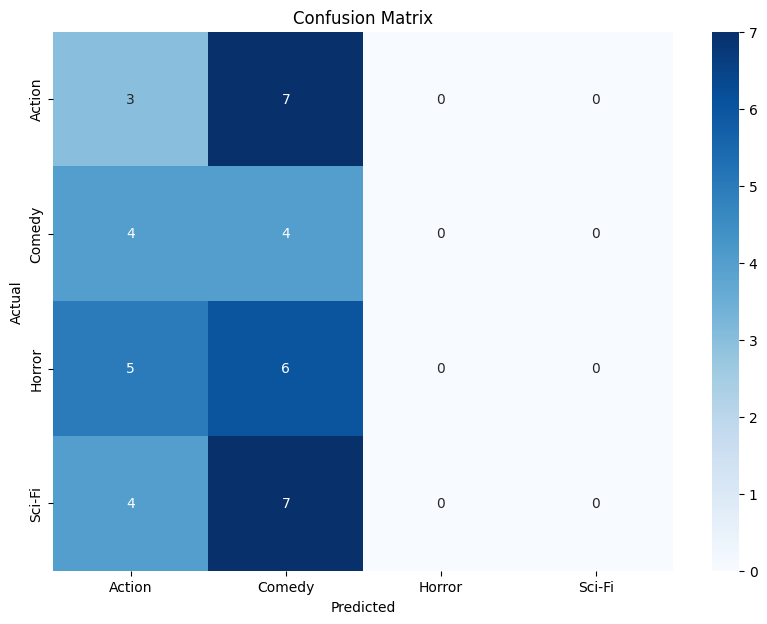

In [ ]:
# Define true labels for the validation dataset if you haven't already
true_labels = val_labels_encoded  # Ensure this matches your actual validation labels

# Adjust the function to also plot the matrix
def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(classes)))
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(true_labels, predicted_labels, encoder.classes_)


**Compare results with an older class corpus from 7/2/2023!!**

In [ ]:
CORPUS2=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_Public/28257a277195efd68d63f1f024d52af8de32be29/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec56_v3_20230702.csv'


In [ ]:
data2 = pd.read_csv(CORPUS2, encoding="utf-8")

In [ ]:
from datasets import Dataset

# Tokenize and encode labels for data2
tokenized_data2 = tokenizer(data2['Text'].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")
encoded_labels_data2 = encoder.transform(data2["Genre of Movie"].tolist())

# Convert to Hugging Face Dataset
data2_dataset = Dataset.from_dict({"input_ids": tokenized_data2['input_ids'],
                                   "attention_mask": tokenized_data2['attention_mask'],
                                   "labels": encoded_labels_data2})


In [ ]:
# Evaluate on data2
results = trainer.evaluate(data2_dataset)
print(results)


{'eval_loss': 1.3858606815338135, 'eval_runtime': 185.0844, 'eval_samples_per_second': 1.027, 'eval_steps_per_second': 0.259, 'epoch': 2.0}


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Predict
predictions = trainer.predict(data2_dataset)
val_pred_labels = np.argmax(predictions.predictions, axis=-1)

# True labels are in 'labels' of data2_dataset
val_true_labels = data2_dataset['labels']

# F1 Score, Confusion Matrix, and Classification Report
print(classification_report(val_true_labels, val_pred_labels, target_names=encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
print(conf_matrix)


              precision    recall  f1-score   support

      Action       0.25      0.72      0.37        50
      Comedy       0.22      0.20      0.21        50
      Horror       0.00      0.00      0.00        50
      Sci-Fi       0.00      0.00      0.00        40

    accuracy                           0.24       190
   macro avg       0.12      0.23      0.14       190
weighted avg       0.12      0.24      0.15       190

[[36 14  0  0]
 [40 10  0  0]
 [46  4  0  0]
 [23 17  0  0]]


In [ ]:
from transformers import pipeline

# Initialize the pipeline for text classification
model_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# Get predictions
predictions = model_pipeline(val_texts, truncation=True)


In [ ]:
import numpy as np

# Extract the label with the highest score from each prediction
val_predicted_labels = [max(pred, key=lambda x: x['score'])['label'] for pred in predictions]

# Convert labels from format 'LABEL_X' to actual names if needed
# This conversion must match how 'encoder' was originally set up
val_predicted_labels = [encoder.classes_[int(label.split('_')[1])] for label in val_predicted_labels]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(val_labels, val_predicted_labels)
f1 = f1_score(val_labels, val_predicted_labels, average='weighted')  # Use 'micro', 'macro', or 'weighted' for multi-class problems

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")


Accuracy: 0.175
F1 Score: 0.10769230769230768


In [ ]:
# This is the validation version of the confusion matrix.
# In the future, I will merge both versions of the print_confusion_matrix()

def print_confusion_matrix__val(true_labels, predicted_labels, classes):
    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=classes)

    # Create a DataFrame from the confusion matrix
    cm_df = pd.DataFrame(cm, index=[encoder.classes_[i] for i in classes], columns=[encoder.classes_[i] for i in classes])

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(cm_df)

In [ ]:
predictions = model_pipeline(data2['Text'].tolist(), truncation=True)  # Ensure this list covers all data points
val_predicted_labels = [max(pred, key=lambda x: x['score'])['label'] for pred in predictions]
val_predicted_labels = [encoder.classes_[int(label.split('_')[1])] for label in val_predicted_labels]  # Correct this line if needed


In [ ]:
# Assuming `val_predicted_labels` are currently string labels as per the encoder's classes
if isinstance(val_predicted_labels[0], str):
    # Convert string labels to their corresponding numeric indices
    val_predicted_labels = [encoder.classes_.tolist().index(label) for label in val_predicted_labels]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# Ensure labels for comparison are in the same format
# Assuming `val_true_labels` are numeric and you've already transformed `val_predicted_labels` correctly

# Generate and print the classification report for a detailed performance analysis
print(classification_report(val_true_labels, val_predicted_labels, target_names=encoder.classes_))


              precision    recall  f1-score   support

      Action       0.25      0.72      0.37        50
      Comedy       0.22      0.20      0.21        50
      Horror       0.00      0.00      0.00        50
      Sci-Fi       0.00      0.00      0.00        40

    accuracy                           0.24       190
   macro avg       0.12      0.23      0.14       190
weighted avg       0.12      0.24      0.15       190



In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[36 14  0  0]
 [40 10  0  0]
 [46  4  0  0]
 [23 17  0  0]]


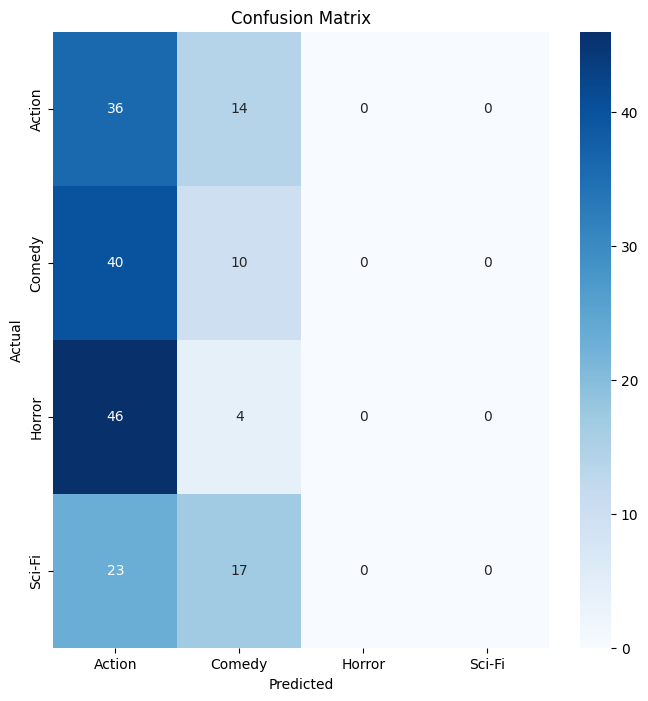

In [ ]:
# Create a more visual representation of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#data['Genre of Movie'].value_counts()

In [ ]:
#print(encoder.classes_)